In [1]:
from pathlib import Path
import pandas as pd
from scipy.stats import ttest_ind, f_oneway
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = Path('./data/').resolve()
!dir {data_path}

 Volume in drive D is Acer
 Volume Serial Number is 2E89-465A

 Directory of D:\PyProject\inno_stats_2020\data

15-May-21  20:19    <DIR>          .
15-May-21  20:19    <DIR>          ..
08-Apr-21  21:02     2,933,464,924 09_groups.csv
08-Apr-21  21:06     3,235,813,850 10_groups.csv
08-Apr-21  21:10     3,271,007,889 11_groups.csv
12-May-21  22:54           342,564 bad_ids.csv
07-Apr-21  20:46           193,519 product_groups.csv
               5 File(s)  9,440,822,746 bytes
               2 Dir(s)  187,567,456,256 bytes free


In [3]:
g_9 = pd.read_csv('./data/09_groups.csv')
g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [4]:
g_9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42100858 entries, 0 to 42100857
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   id_doc    int64  
 2   id_order  float64
 3   id_card   int64  
 4   id_tov    int64  
 5   id_kontr  int64  
 6   quantity  float64
 7   sum       float64
 8   is_green  int64  
 9   id_group  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 3.1+ GB


Remove outliers:

In [5]:
outliers_df = pd.read_csv('./data/bad_ids.csv')
outliers_df.head()

,Unnamed: 0,id_card
0,0,806096
1,1,1438102
2,2,72344
3,3,427981
4,4,1528414


In [6]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24707 entries, 0 to 24706
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  24707 non-null  int64
 1   id_card     24707 non-null  int64
dtypes: int64(2)
memory usage: 386.2 KB


In [7]:
cond = g_9['id_card'].isin(outliers_df['id_card'])
g_9.drop(g_9[cond].index, inplace = True)
g_9.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38466003 entries, 0 to 42100857
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   id_doc    int64  
 2   id_order  float64
 3   id_card   int64  
 4   id_tov    int64  
 5   id_kontr  int64  
 6   quantity  float64
 7   sum       float64
 8   is_green  int64  
 9   id_group  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 3.2+ GB


In [8]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


In [9]:
p_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5650 entries, 0 to 5649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_tov      5650 non-null   int64 
 1   id_group    5650 non-null   int64 
 2   name_group  5650 non-null   object
dtypes: int64(2), object(1)
memory usage: 132.5+ KB


# Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

$H_0$ : Buying discounted products does not depend on the average order (receipt) sum

$H_a$ : Buying discounted products depend on the average order (receipt) sum

Get mean sum of the orders:

In [10]:
mean_sum = g_9.groupby("id_doc")['sum'].mean()
mean_sum

id_doc
2            66.000000
4            93.941176
5           127.000000
16          101.294286
18          101.000000
               ...    
23417859    115.333333
23417862     28.800000
23417864     64.800000
23417867    209.560000
23417869     40.000000
Name: sum, Length: 6904825, dtype: float64

Get number of discounted products per order (receipt):

In [11]:
discounted_number = g_9.groupby("id_doc")['is_green'].sum()
discounted_number

id_doc
2           0
4           0
5           0
16          0
18          0
           ..
23417859    0
23417862    3
23417864    0
23417867    0
23417869    0
Name: is_green, Length: 6904825, dtype: int64

Get orders with and without discounts:

In [12]:
discount_customers = discounted_number.index[discounted_number.to_numpy().nonzero()]
non_discount_customers = list(set(discounted_number.index) - set(discount_customers))

Use two-sided t-test to determine if there is a significant difference between the means of two groups:

In [13]:
ttest_ind(mean_sum.reindex(index = discount_customers), mean_sum.reindex(index = non_discount_customers))

Ttest_indResult(statistic=-379.1254533395915, pvalue=0.0)

As can be seen from t-test, there is a difference between between order sums with and without discounts.
So, there is a dependency between discounted products and the average order (receipt) sum. $H_0$ rejected.

# Task 2
Prove that the frequency of shopping grows around the wage taking days.

$H_0$ The frequency of shopping does not grow after the wage taking days (1-6 days of each month, 20 -26 days of each month)

$H_a$ The frequency is different.

So, let's plot number of checkouts per day for September and look to distribution

In [14]:
g_9.index = pd.to_datetime(g_9['date'],format='%Y-%m-%d %H:%M:%S')
number_checkouts = g_9.groupby(g_9.index.day)['id_order'].count().to_frame()
number_checkouts

,id_order
date,
1,1269893
2,1285415
3,1287425
4,1270192
5,1053459
6,1158077
7,1371646
8,1227093
9,1336351


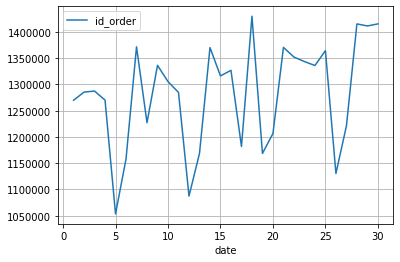

In [15]:
number_checkouts.plot()
plt.grid()

Let's compute F-test for wage and usual days

In [16]:
days_list = number_checkouts['id_order'].to_list()
wage_days = days_list[0:6] + days_list[19:26]
usual_days = days_list[6:19] + days_list[26:]

f_oneway(wage_days, usual_days)

F_onewayResult(statistic=0.7525409594081744, pvalue=0.3930470256225759)

P-value is too high. So, we failed to reject $H_0$.
There is no difference between wage and usual days.

# Task 3
Define such cohort existence:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

### Frequent buyers

(array([8.27393e+05, 2.15854e+05, 1.09664e+05, 6.42470e+04, 3.93710e+04,
        2.64890e+04, 1.67030e+04, 1.16070e+04, 7.63100e+03, 5.23300e+03,
        3.33700e+03, 2.38400e+03, 1.40500e+03, 9.28000e+02, 6.01000e+02,
        4.17000e+02, 2.49000e+02, 1.77000e+02, 1.04000e+02, 5.40000e+01,
        4.30000e+01, 2.00000e+01, 1.50000e+01, 9.00000e+00, 9.00000e+00,
        7.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  1.        ,  21.17142857,  41.34285714,  61.51428571,
         81.68571429, 101.85714286, 122.02857143, 142.2       ,
        162.37142857, 182.54285714, 202.71428571, 222.88571429,
        243.05714286, 263.22857143, 283.4       , 303.57142857,
        323.74285714, 343.91428571, 364.08571429, 384.25714286,
        404.42857143, 424.6       , 444.77142857, 464.94285714,
        485.11428571, 505.28571429, 525.45714286, 545.62857143,
        565.8       , 585.97142857, 606

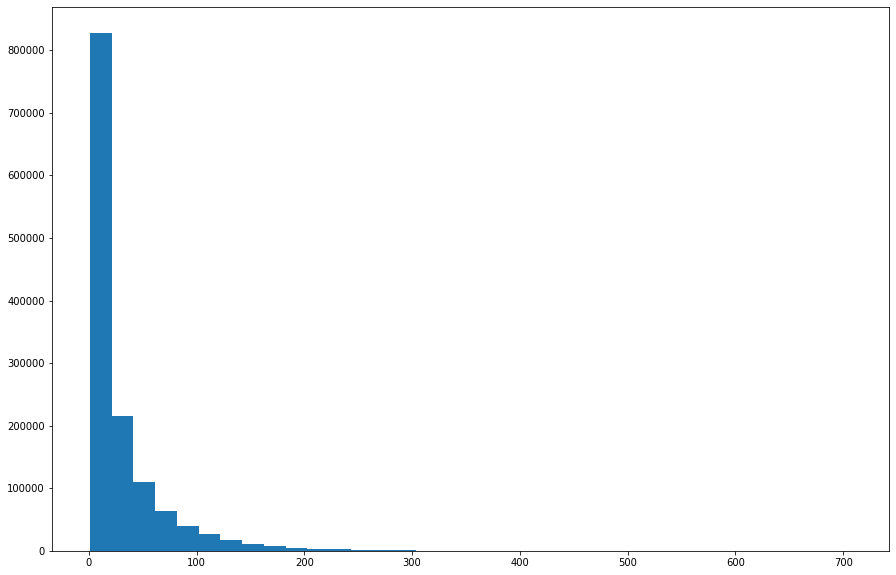

In [17]:
customer_count = g_9.groupby('id_card')['id_doc'].count()

plt.figure(figsize=(15, 10))
plt.hist(customer_count, bins=35)

### Average purchase sum

In [18]:
stds = g_9.groupby('id_card')['sum'].std()
counts = g_9.groupby('id_card')['sum'].count()

Let's look at variance for each customer. Regular customer is who have made at least ten purchases.

In [19]:
is_regular = counts > 10
regular = is_regular.index[np.where(is_regular)[0]]
regular_stds = stds[regular]

Let's define the minimal std as +-250 RUB for people to be included.

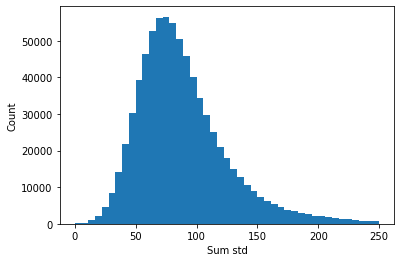

In [20]:
regular_stds = regular_stds[regular_stds < 250]
plt.xlabel('Sum std')
plt.ylabel('Count')
plt.hist(regular_stds, bins=45);

### Usual cart

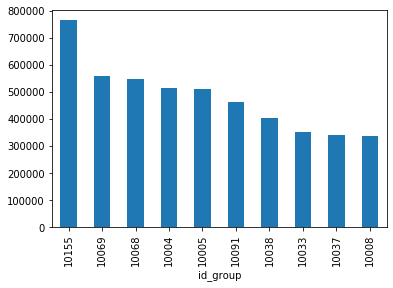

In [21]:
df = g_9[g_9.id_group != -9999]
customers_to_group = df.groupby('id_group')['id_card'].unique().apply(len)
customers_to_group = customers_to_group.sort_values(ascending=False)
customers_to_group[:10].plot(kind='bar')

In [22]:
common_groups = p_g[p_g.id_group.isin(customers_to_group[:20].index)]
common_groups.drop_duplicates('id_group', 'first', inplace=True)
common_groups[['name_group']].head()


C:\Users\aliek\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,name_group
0,Кисломолочные продукты
43,Творог
93,"Торты, пирожные, муссы, суфле"
960,"Выпечка, печенье, вафли, пряники"
1032,"Леденцы, мармелад, халва, зефир, восточные сла..."


Here is the list the most popular products
